IMPORT LIBRARIES

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


LOAD DATASET

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [114]:
data = pd.read_csv('/content/drive/MyDrive/xai/Darknet/Darknet.csv')

In [115]:
import pandas as pd

# Assuming your DataFrame is named df
nan_rows = data[data.isnull().any(axis=1)]

# To get the count of rows with NaN values
count_nan_rows = nan_rows.shape[0]

print(f"Number of rows with NaN values: {count_nan_rows}")

Number of rows with NaN values: 47


DATA PREPARATION AND PREPROCESSING

In [116]:
data.shape

(141530, 85)

In [117]:
data['Label'].value_counts()

Label
Non-Tor    93356
NonVPN     23863
VPN        22919
Tor         1392
Name: count, dtype: int64

In [118]:
#dropping invalid columns
data = data.drop(['Flow ID','Src IP','Dst IP','Timestamp'],axis=1)

In [119]:
data.shape

(141530, 81)

In [120]:
data = data.drop(['Label.1'],axis=1)

In [121]:
# Replace infinity values with NaN in training and testing sets
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with class-wise means
class_column = 'Label'

# Calculate class-wise means
class_means = data.groupby(class_column).transform(lambda x: x.fillna(x.mean()))

# Fill NaN values with class-wise means
data = data.fillna(class_means)

In [122]:
#label encoding categorical variable
encoder = LabelEncoder()
data.Label = encoder.fit_transform(data.Label)
data.Label

0         0
1         0
2         0
3         0
4         0
         ..
141525    3
141526    3
141527    3
141528    3
141529    3
Name: Label, Length: 141530, dtype: int64

In [15]:
"""#Code for selecting features based on SHAP

# Assuming shap_values and X_test are already defined
shap.summary_plot(shap_values, X_test, class_names=['Non-Tor', 'NonVPN', 'Tor', 'VPN'], max_display=10, show=False)  #change max_display value to get tp features

# Get the y-ticks (class labels)
yticks = plt.gca().get_yticklabels()

print("Y-ticks (class labels):", [ytick.get_text() for ytick in yticks])"""

'#Code for selecting features based on SHAP\n\n# Assuming shap_values and X_test are already defined\nshap.summary_plot(shap_values, X_test, class_names=[\'Non-Tor\', \'NonVPN\', \'Tor\', \'VPN\'], max_display=10, show=False)  #change max_display value to get tp features\n\n# Get the y-ticks (class labels)\nyticks = plt.gca().get_yticklabels()\n\nprint("Y-ticks (class labels):", [ytick.get_text() for ytick in yticks])'

### With 10 Features

In [16]:
# Assuming 'data' is your dataframe
columns_to_keep = ['Flow IAT Min', 'Fwd Seg Size Min', 'Bwd Packets/s', 'Idle Mean', 'Bwd Packet Length Min', 'Src Port', 'Bwd Init Win Bytes', 'Dst Port', 'FWD Init Win Bytes', 'Idle Max','Label']

# Filter 'data' dataframe to keep only the specified columns
data_10 = data[columns_to_keep]


In [17]:
data_10.shape

(141530, 11)

In [18]:
#split the dataset into independent and dependent variables
X = data_10.iloc[:,:-1]
y = data_10.iloc[:,-1]

In [19]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [20]:
from xgboost import XGBClassifier

In [21]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [22]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [23]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.2829732894897461 seconds
Prediction time per sample: 7.997436325064187e-06 seconds


In [24]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [25]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.97      0.96      6016
           2       0.99      0.91      0.95       374
           3       0.97      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9853319390667835


In [26]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9853195799482976

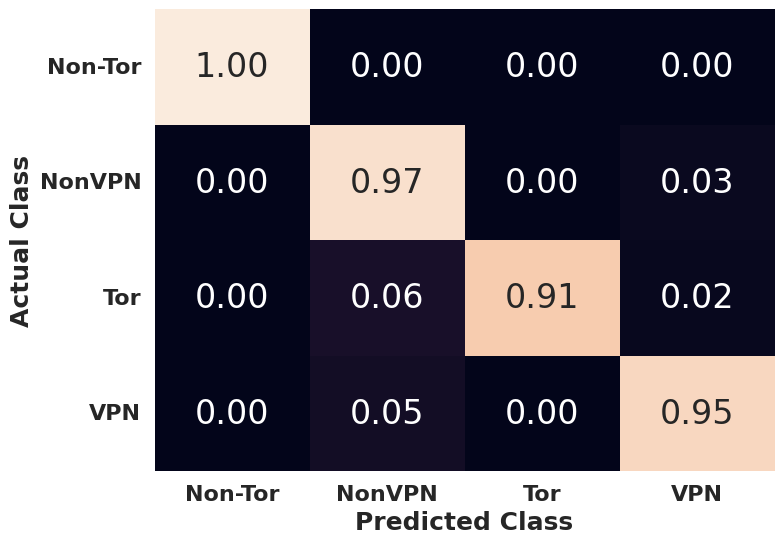

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


### With 20 Features

In [28]:
# Assuming 'data' is your dataframe
columns_to_keep = ['Fwd Header Length', 'Flow Duration', 'Idle Min', 'Flow IAT Max', 'Fwd Act Data Pkts', 'Flow Bytes/s', 'Fwd Packets/s', 'Packet Length Max', 'Total Length of Fwd Packet', 'Packet Length Std', 'Flow IAT Min', 'Fwd Seg Size Min', 'Bwd Packets/s', 'Idle Mean', 'Bwd Packet Length Min', 'Src Port', 'Bwd Init Win Bytes', 'Dst Port', 'FWD Init Win Bytes', 'Idle Max','Label']

# Filter 'data' dataframe to keep only the specified columns
data_20 = data[columns_to_keep]


In [29]:
data_20.shape

(141530, 21)

In [30]:
#split the dataset into independent and dependent variables
X = data_20.iloc[:,:-1]
y = data_20.iloc[:,-1]

In [31]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [32]:
from xgboost import XGBClassifier

In [33]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [34]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [35]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.301332950592041 seconds
Prediction time per sample: 8.516320000905547e-06 seconds


In [36]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [37]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.93      0.96       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9868580956956731


In [38]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9868477501259928

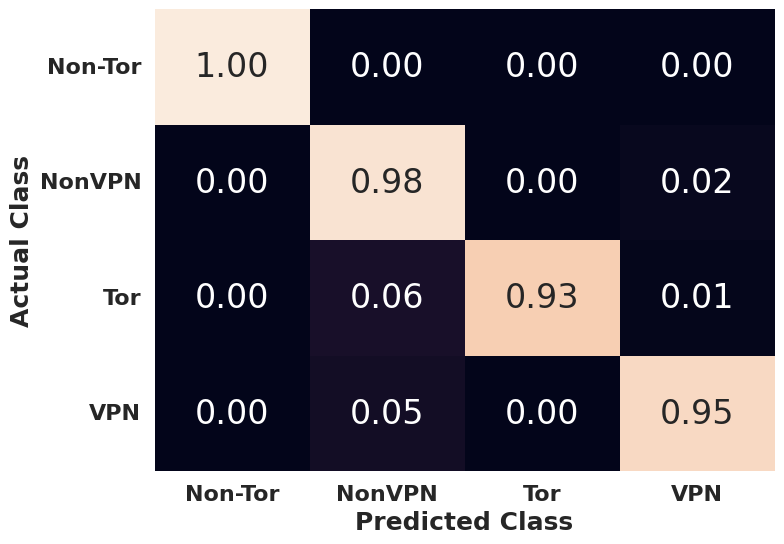

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


### With 30 Features

In [40]:
# Assuming 'data' is your dataframe
columns_to_keep = ['Fwd Packet Length Min', 'Packet Length Min', 'Total Bwd packets', 'Fwd Packet Length Mean', 'Subflow Fwd Bytes', 'Fwd IAT Mean', 'Fwd IAT Min', 'Flow Packets/s', 'Fwd IAT Total', 'Flow IAT Mean', 'Fwd Header Length', 'Flow Duration', 'Idle Min', 'Flow IAT Max', 'Fwd Act Data Pkts', 'Flow Bytes/s', 'Fwd Packets/s', 'Packet Length Max', 'Total Length of Fwd Packet', 'Packet Length Std', 'Flow IAT Min', 'Fwd Seg Size Min', 'Bwd Packets/s', 'Idle Mean', 'Bwd Packet Length Min', 'Src Port', 'Bwd Init Win Bytes', 'Dst Port', 'FWD Init Win Bytes', 'Idle Max','Label']

# Filter 'data' dataframe to keep only the specified columns
data_30 = data[columns_to_keep]


In [41]:
data_30.shape

(141530, 31)

In [42]:
#split the dataset into independent and dependent variables
X = data_30.iloc[:,:-1]
y = data_30.iloc[:,-1]

In [43]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [44]:
from xgboost import XGBClassifier

In [45]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [46]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [47]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.29654669761657715 seconds
Prediction time per sample: 8.381050154497276e-06 seconds


In [48]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [49]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.92      0.95       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9866885227369075


In [50]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9866755166912611

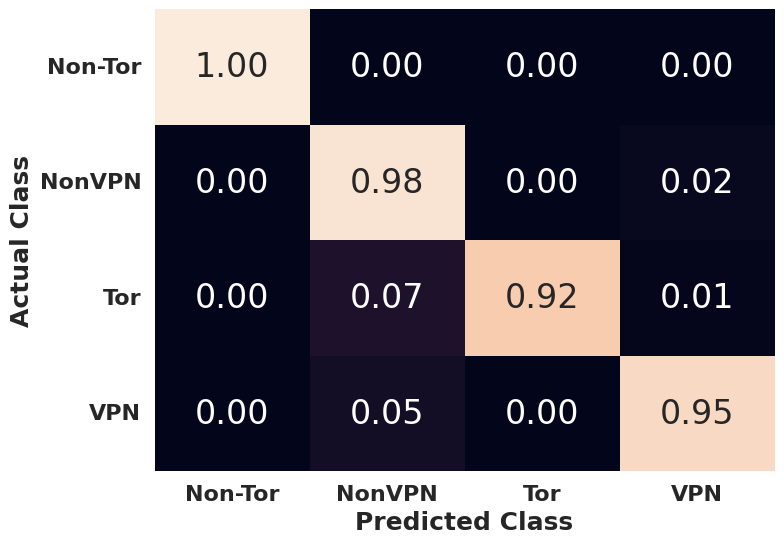

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


### With 40 Features

In [52]:
# Assuming 'data' is your dataframe
columns_to_keep = ['RST Flag Count', 'FIN Flag Count', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'SYN Flag Count', 'Total Length of Bwd Packet', 'Subflow Bwd Bytes', 'Fwd IAT Max', 'Average Packet Size', 'Packet Length Mean', 'Fwd Packet Length Min', 'Packet Length Min', 'Total Bwd packets', 'Fwd Packet Length Mean', 'Subflow Fwd Bytes', 'Fwd IAT Mean', 'Fwd IAT Min', 'Flow Packets/s', 'Fwd IAT Total', 'Flow IAT Mean', 'Fwd Header Length', 'Flow Duration', 'Idle Min', 'Flow IAT Max', 'Fwd Act Data Pkts', 'Flow Bytes/s', 'Fwd Packets/s', 'Packet Length Max', 'Total Length of Fwd Packet', 'Packet Length Std', 'Flow IAT Min', 'Fwd Seg Size Min', 'Bwd Packets/s', 'Idle Mean', 'Bwd Packet Length Min', 'Src Port', 'Bwd Init Win Bytes', 'Dst Port', 'FWD Init Win Bytes', 'Idle Max','Label']

# Filter 'data' dataframe to keep only the specified columns
data_40 = data[columns_to_keep]


In [53]:
data_40.shape

(141530, 41)

In [54]:
#split the dataset into independent and dependent variables
X = data_40.iloc[:,:-1]
y = data_40.iloc[:,-1]

In [55]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [56]:
from xgboost import XGBClassifier

In [57]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [58]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [59]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.3124563694000244 seconds
Prediction time per sample: 8.830691840715158e-06 seconds


In [60]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [61]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.91      0.95       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9871972416132041


In [62]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9871821592331993

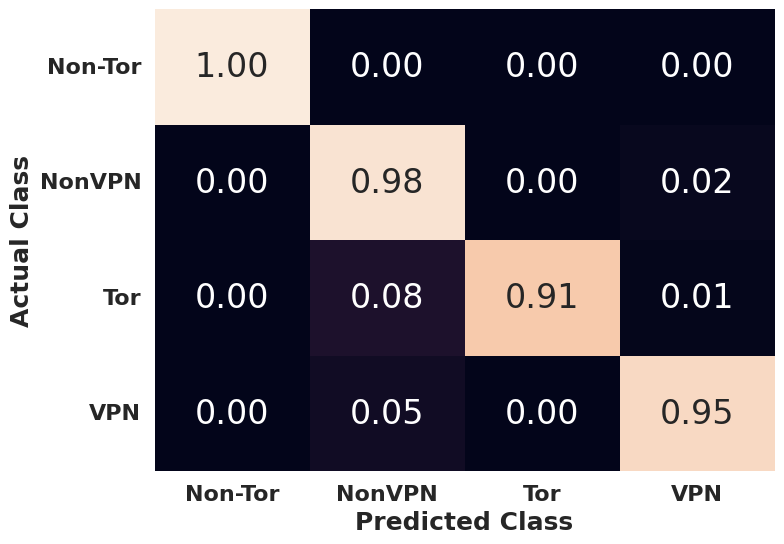

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


### With 50 Features

In [65]:
# Assuming 'data' is your dataframe
columns_to_keep = ['Protocol', 'Bwd IAT Min', 'Fwd Packet Length Std', 'PSH Flag Count', 'Bwd Packet Length Std', 'ACK Flag Count', 'Flow IAT Std', 'Bwd Header Length', 'Bwd Packet Length Max', 'Fwd IAT Std', 'RST Flag Count', 'FIN Flag Count', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'SYN Flag Count', 'Total Length of Bwd Packet', 'Subflow Bwd Bytes', 'Fwd IAT Max', 'Average Packet Size', 'Packet Length Mean', 'Fwd Packet Length Min', 'Packet Length Min', 'Total Bwd packets', 'Fwd Packet Length Mean', 'Subflow Fwd Bytes', 'Fwd IAT Mean', 'Fwd IAT Min', 'Flow Packets/s', 'Fwd IAT Total', 'Flow IAT Mean', 'Fwd Header Length', 'Flow Duration', 'Idle Min', 'Flow IAT Max', 'Fwd Act Data Pkts', 'Flow Bytes/s', 'Fwd Packets/s', 'Packet Length Max', 'Total Length of Fwd Packet', 'Packet Length Std', 'Flow IAT Min', 'Fwd Seg Size Min', 'Bwd Packets/s', 'Idle Mean', 'Bwd Packet Length Min', 'Src Port', 'Bwd Init Win Bytes', 'Dst Port', 'FWD Init Win Bytes', 'Idle Max','Label']
# Filter 'data' dataframe to keep only the specified columns
data_50 = data[columns_to_keep]


In [66]:
data_50.shape

(141530, 51)

In [67]:
#split the dataset into independent and dependent variables
X = data_50.iloc[:,:-1]
y = data_50.iloc[:,-1]

In [68]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [69]:
from xgboost import XGBClassifier

In [70]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [71]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [72]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.31487083435058594 seconds
Prediction time per sample: 8.898929834965546e-06 seconds


In [73]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [74]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.92      0.96       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9871689794534099


In [75]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9871553852856605

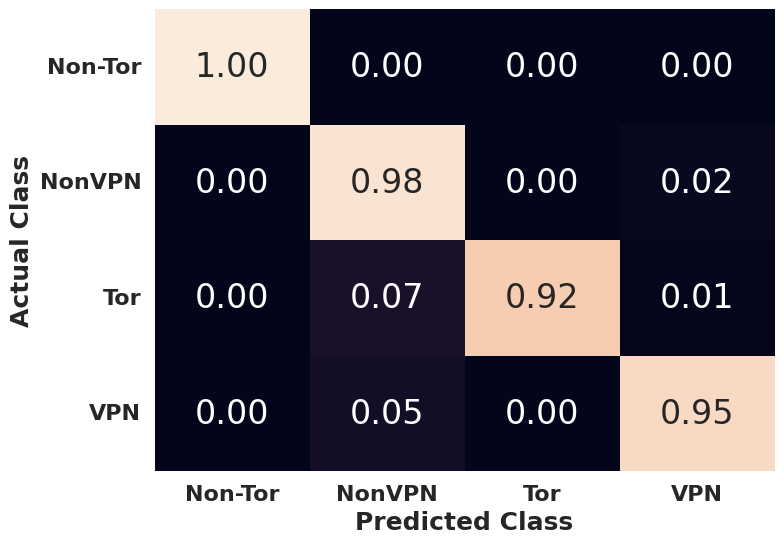

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


### With 60 Features

In [77]:
# Assuming 'data' is your dataframe
columns_to_keep = ['Bwd Packet/Bulk Avg', 'Bwd IAT Max', 'Bwd IAT Mean', 'Down/Up Ratio', 'Bwd Bulk Rate Avg', 'Idle Std', 'Bwd IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', 'Total Fwd Packet', 'Protocol', 'Bwd IAT Min', 'Fwd Packet Length Std', 'PSH Flag Count', 'Bwd Packet Length Std', 'ACK Flag Count', 'Flow IAT Std', 'Bwd Header Length', 'Bwd Packet Length Max', 'Fwd IAT Std', 'RST Flag Count', 'FIN Flag Count', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'SYN Flag Count', 'Total Length of Bwd Packet', 'Subflow Bwd Bytes', 'Fwd IAT Max', 'Average Packet Size', 'Packet Length Mean', 'Fwd Packet Length Min', 'Packet Length Min', 'Total Bwd packets', 'Fwd Packet Length Mean', 'Subflow Fwd Bytes', 'Fwd IAT Mean', 'Fwd IAT Min', 'Flow Packets/s', 'Fwd IAT Total', 'Flow IAT Mean', 'Fwd Header Length', 'Flow Duration', 'Idle Min', 'Flow IAT Max', 'Fwd Act Data Pkts', 'Flow Bytes/s', 'Fwd Packets/s', 'Packet Length Max', 'Total Length of Fwd Packet', 'Packet Length Std', 'Flow IAT Min', 'Fwd Seg Size Min', 'Bwd Packets/s', 'Idle Mean', 'Bwd Packet Length Min', 'Src Port', 'Bwd Init Win Bytes', 'Dst Port', 'FWD Init Win Bytes', 'Idle Max','Label']

# Filter 'data' dataframe to keep only the specified columns
data_60 = data[columns_to_keep]


In [78]:
data_60.shape

(141530, 61)

In [79]:
#split the dataset into independent and dependent variables
X = data_60.iloc[:,:-1]
y = data_60.iloc[:,-1]

In [80]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [81]:
from xgboost import XGBClassifier

In [82]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [83]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [84]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.5445852279663086 seconds
Prediction time per sample: 1.5391154734372683e-05 seconds


In [85]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [86]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.93      0.95       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9871972416132041


In [87]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9871876801788155

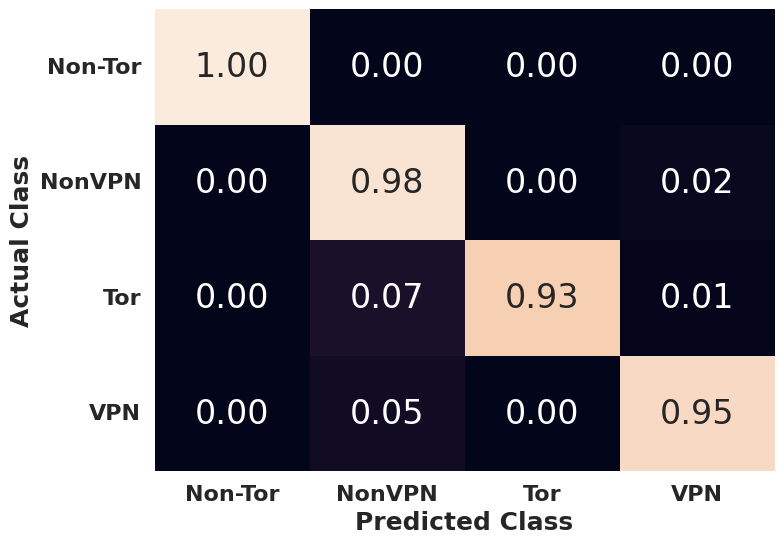

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


### With 70 Features

In [90]:
# Assuming 'data' is your dataframe
columns_to_keep = ['Bwd URG Flags', 'Bwd Segment Size Avg', 'Fwd Bytes/Bulk Avg', 'Fwd Segment Size Avg', 'ECE Flag Count', 'URG Flag Count', 'Packet Length Variance', 'Active Std', 'Active Max', 'Active Mean', 'Bwd Packet/Bulk Avg', 'Bwd IAT Max', 'Bwd IAT Mean', 'Down/Up Ratio', 'Bwd Bulk Rate Avg', 'Idle Std', 'Bwd IAT Std', 'Bwd IAT Total', 'Fwd PSH Flags', 'Total Fwd Packet', 'Protocol', 'Bwd IAT Min', 'Fwd Packet Length Std', 'PSH Flag Count', 'Bwd Packet Length Std', 'ACK Flag Count', 'Flow IAT Std', 'Bwd Header Length', 'Bwd Packet Length Max', 'Fwd IAT Std', 'RST Flag Count', 'FIN Flag Count', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'SYN Flag Count', 'Total Length of Bwd Packet', 'Subflow Bwd Bytes', 'Fwd IAT Max', 'Average Packet Size', 'Packet Length Mean', 'Fwd Packet Length Min', 'Packet Length Min', 'Total Bwd packets', 'Fwd Packet Length Mean', 'Subflow Fwd Bytes', 'Fwd IAT Mean', 'Fwd IAT Min', 'Flow Packets/s', 'Fwd IAT Total', 'Flow IAT Mean', 'Fwd Header Length', 'Flow Duration', 'Idle Min', 'Flow IAT Max', 'Fwd Act Data Pkts', 'Flow Bytes/s', 'Fwd Packets/s', 'Packet Length Max', 'Total Length of Fwd Packet', 'Packet Length Std', 'Flow IAT Min', 'Fwd Seg Size Min', 'Bwd Packets/s', 'Idle Mean', 'Bwd Packet Length Min', 'Src Port', 'Bwd Init Win Bytes', 'Dst Port', 'FWD Init Win Bytes', 'Idle Max','Label']
# Filter 'data' dataframe to keep only the specified columns
data_70 = data[columns_to_keep]


In [91]:
data_70.shape

(141530, 71)

In [92]:
#split the dataset into independent and dependent variables
X = data_70.iloc[:,:-1]
y = data_70.iloc[:,-1]

In [93]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [94]:
from xgboost import XGBClassifier

In [95]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [96]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [97]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.8960022926330566 seconds
Prediction time per sample: 2.532295997041112e-05 seconds


In [98]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [99]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.93      0.96       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9870559308142328


In [100]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9870450319186758

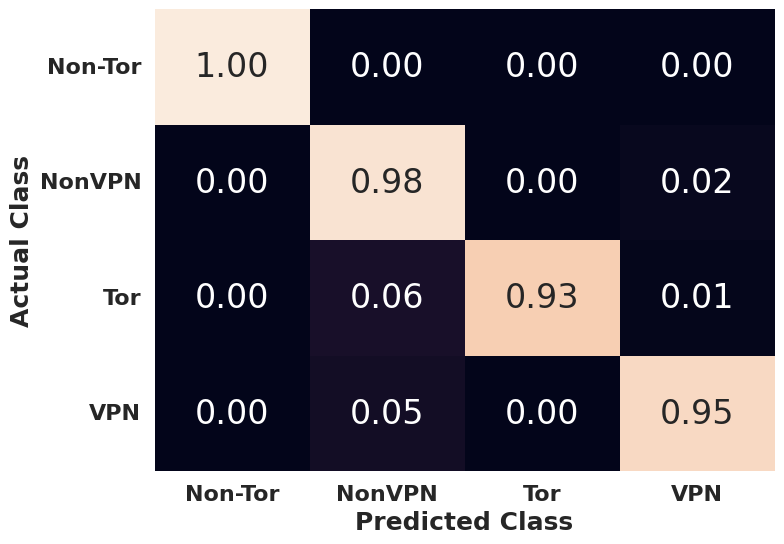

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


### With Full Features

In [123]:
data.shape

(141530, 80)

In [126]:
#split the dataset into independent and dependent variables
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [127]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

MODEL TRAINING

In [128]:
from xgboost import XGBClassifier

In [129]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [130]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [141]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.34103918075561523 seconds
Prediction time per sample: 9.63850382261581e-06 seconds


In [132]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [133]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.92      0.95       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9871124551338213


In [134]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9871005516667765

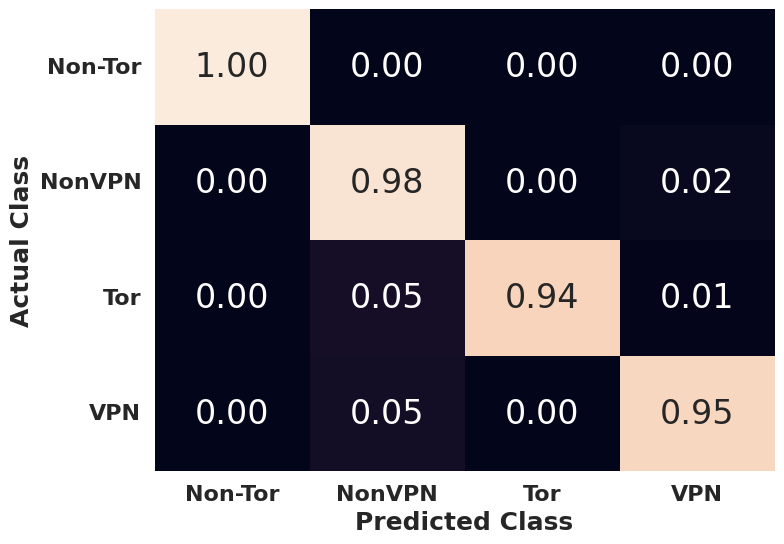

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


**Performance Comparison with different number of Features**

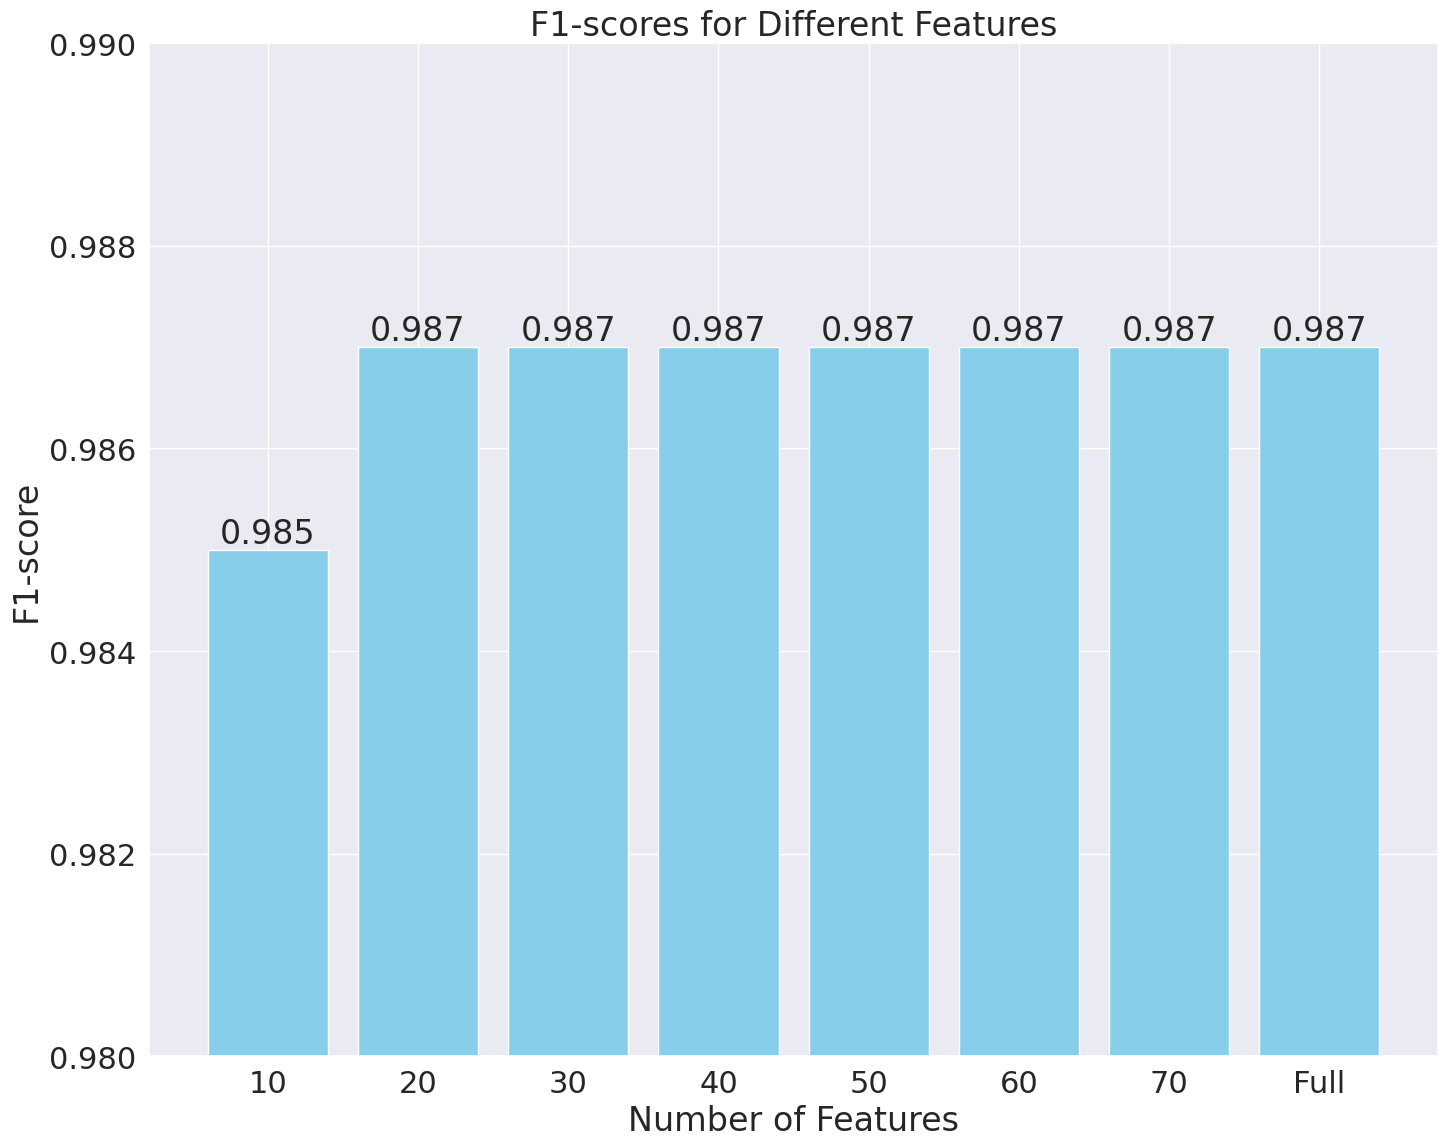

In [147]:
import matplotlib.pyplot as plt

# Data
features = ['10', '20', '30', '40', '50', '60', '70', 'Full']
f1_scores = [0.985, 0.987, 0.987, 0.987, 0.987, 0.987, 0.987, 0.987]

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(15, 12))

# Bar chart for F1-scores
bars1 = ax1.bar(features, f1_scores, color='skyblue')
ax1.set_title('F1-scores for Different Features')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('F1-score')
ax1.set_ylim([0.980, 0.990])

# Add data labels for F1-scores
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

